In [1]:
import sys
sys.path.append('..')
from utilities import defaultPlotting, formatP, formatCell, readDiffTAD

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from pybedtools import BedTool
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def sampleByGroup(df, group, samplesPerGroup):
    """ Perform random sampling with different numbers
        per group. i.e. maintain frequency by chromosome. """
    grouped = df.groupby(group)
    return (grouped.apply(lambda x: x.sample(samplesPerGroup[x.name])))

In [3]:
df = pd.read_pickle('conservedTADs.pkl')
valid = (df['allNormal']) & (df['High_Signal_Region'] == 0) & (df['Low_Mappability'] == 0)
df = df.loc[valid]

df['ref'] = df['nASTAD'] == 3 # Define 3-way conserved

In [9]:
boundarySize = 20000

df['start2'] = df['start'] + boundarySize
df['end2'] = df['end'] - boundarySize

columns = ['chrom', 'start', 'end', 'ref']

leftBoundaries = df[['chrom', 'start', 'start2', 'ref']]
leftBoundaries.columns = columns
rightBoundaries = df[['chrom', 'end2', 'end', 'ref']]
rightBoundaries.columns = columns

boundaries = pd.concat([leftBoundaries, rightBoundaries])

In [13]:
boundaries = boundaries.groupby(['chrom', 'start', 'end'])['ref'].apply(lambda x: x.sum() > 0).reset_index()

In [21]:
intervalOfInterest = ({
    'VCF': BedTool('../0.processVCFs/intersection/3wayHetVar.bed'),
    'GM12878-ASM': BedTool('../0.ASM/GM12878-ASM-All-GSM1002650-hg19.bed'),
    'H1hESC-ASM': BedTool('../0.ASM/H1hESC-ASM-All-GSM1002649-hg19.bed'),
    'IMR90-ASM': BedTool('../0.ASM/IMR90-ASM-All-GSM2210597-hg19.bed')
})

/tmp/ipykernel_17062/3894595157.py:24: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  intervalOverlaps = pd.merge(
/tmp/ipykernel_17062/3894595157.py:24: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  intervalOverlaps = pd.merge(
/tmp/ipykernel_17062/3894595157.py:24: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  intervalOverlaps = pd.merge(
/tmp/ipykernel_17062/3894595157.py:24: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  intervalOverlaps = pd.merge(


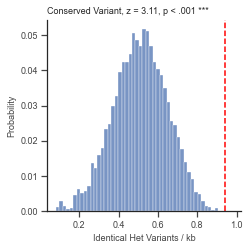

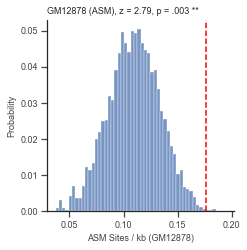

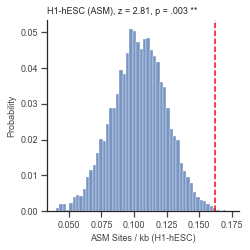

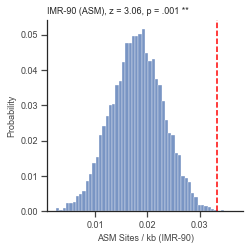

In [22]:
np.random.seed(4248)

nReps = 10000
scale = 1000 # Report var frequency per scale bases (e.g. per kb)

defaultPlotting(9, width=90, ratio=1)

for refName, refIntervals in intervalOfInterest.items():

    intervals = df[['chrom','start', 'end', 'ref']].copy() #boundaries.copy()
    
    sampleGroups = defaultdict(int, intervals.loc[intervals['ref']].groupby('chrom').size().to_dict())

    # Compute number of conserved SNPs overlapping each region
    names = ['chrom2', 'start2', 'end2', 'chrom', 'start', 'end', 'ref']        
    intervalOverlaps = (
        refIntervals.intersect(BedTool.from_dataframe(intervals), wa=True, wb=True)
        .to_dataframe(names=names)
        .groupby(['chrom', 'start', 'end', 'ref'])
        .size().reset_index().rename({0: 'N'}, axis=1))

    # Merge back in to include regions with 0 count
    mergeBy = ['chrom', 'start', 'end', 'ref']
    intervalOverlaps = pd.merge(
        intervals, intervalOverlaps, 
        left_on=mergeBy, right_on=mergeBy, how='left').fillna(0)

    refOnly = intervalOverlaps.loc[intervalOverlaps['ref']]
    refSize = (refOnly['end'] - refOnly['start']).sum()
    obs = (refOnly['N'].sum()/ refSize) * scale

    exp = []
    for rep in range(nReps):
        sub = sampleByGroup(intervalOverlaps, 'chrom', sampleGroups)
        size = (sub['end'] - sub['start']).sum()
        n = sub['N'].sum()
        exp.append((n / size) * scale)
    exp = np.array(exp)

    z = (obs - exp.mean()) / exp.std()
    p = formatP(1 - norm.cdf(z))

    fig, ax = plt.subplots()
    sns.histplot(x=exp, stat='probability', ax=ax)

    ax.axvline(obs, color='red', ls='--')

    if refName == 'VCF':
        ax.set_xlabel(f'Identical Het Variants / kb')
        title = f'Conserved Variant, z = {z:.2f}, p {p}'
    else:
        cell = formatCell(refName.split('-')[0])
        ax.set_xlabel(f'ASM Sites / kb ({cell})')
        title = f'{cell} (ASM), z = {z:.2f}, p {p}'
    ax.set_title(title, loc='left')
    fig.tight_layout()
    fig.savefig(f'plots/{refName}-TADboundaries.svg')

In [23]:
obs

0.03334595003785011